In [1]:
import shutup
shutup.please()

import gym
import src.environments.continuous.stock_trading  

import numpy as np
import pandas as pd 

from tqdm.notebook import trange, tqdm

In [2]:
env = gym.make('StockTradingEnvironment-v0', use_technical_indicators= [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
])

In [3]:
from src.agents.actor_critic.a2c import A2CAgent

In [4]:
def environment():
    env = gym.make('StockTradingEnvironment-v0',
                   use_technical_indicators= [
        "macd",
        "boll_ub",
        "boll_lb",
        "rsi_30",
        "cci_30",
        "dx_30",
        "close_30_sma",
        "close_60_sma",
    ])
    
    env.success_threshold =0.25 # 5%
    return env


In [5]:
agent=A2CAgent(environment, epochs=1, actor_learning_rate=0.000025,critic_learning_rate=0.000025,policy="CNN")
agent.load()
environment().success_threshold


* Models successfully loaded *



0.25

In [6]:
agent.hash

'ed75666dd5e47547b3de000d534a9270'

Episode * 100 * Worker * False * Moving Avg Reward is ==> 0.12958 * Last Reward was ==> 0.09142
Episode * 200 * Worker * False * Moving Avg Reward is ==> 0.13147 * Last Reward was ==> -0.00168
Episode * 300 * Worker * False * Moving Avg Reward is ==> 0.13263 * Last Reward was ==> 0.09699
Episode * 400 * Worker * False * Moving Avg Reward is ==> 0.13411 * Last Reward was ==> 0.07963
Episode * 500 * Worker * False * Moving Avg Reward is ==> 0.13477 * Last Reward was ==> 0.01938
Episode * 600 * Worker * False * Moving Avg Reward is ==> 0.13582 * Last Reward was ==> 0.19914
Episode * 700 * Worker * False * Moving Avg Reward is ==> 0.13459 * Last Reward was ==> 0.13426
Episode * 800 * Worker * False * Moving Avg Reward is ==> 0.13449 * Last Reward was ==> 0.05019
Episode * 900 * Worker * False * Moving Avg Reward is ==> 0.13504 * Last Reward was ==> 0.16165
Episode * 1000 * Worker * False * Moving Avg Reward is ==> 0.13664 * Last Reward was ==> 0.22830
* Models saved *

New historical movin

* Models saved *

New historical moving average record: 0.14443

* Models saved *

New historical moving average record: 0.14445

* Models saved *

New historical moving average record: 0.14449

* Models saved *

New historical moving average record: 0.14451

* Models saved *

New historical moving average record: 0.14464

* Models saved *

New historical moving average record: 0.14464

* Models saved *

New historical moving average record: 0.14474

* Models saved *

New historical moving average record: 0.14485

* Models saved *

New historical moving average record: 0.14490

* Models saved *

New historical moving average record: 0.14502

* Models saved *

New historical moving average record: 0.14514

Episode * 1500 * Worker * False * Moving Avg Reward is ==> 0.14513 * Last Reward was ==> 0.19859
* Models saved *

New historical moving average record: 0.14519

* Models saved *

New historical moving average record: 0.14536

* Models saved *

New historical moving average record: 0.

* Models saved *

New historical moving average record: 0.15262

* Models saved *

New historical moving average record: 0.15265

* Models saved *

New historical moving average record: 0.15270

* Models saved *

New historical moving average record: 0.15275

* Models saved *

New historical moving average record: 0.15277

* Models saved *

New historical moving average record: 0.15283

* Models saved *

New historical moving average record: 0.15284

* Models saved *

New historical moving average record: 0.15300

* Models saved *

New historical moving average record: 0.15302

* Models saved *

New historical moving average record: 0.15307

* Models saved *

New historical moving average record: 0.15309

* Models saved *

New historical moving average record: 0.15315

* Models saved *

New historical moving average record: 0.15330

* Models saved *

New historical moving average record: 0.15347

* Models saved *

New historical moving average record: 0.15361

Episode * 2100 * Worker *

* Models saved *

New historical moving average record: 0.16059

* Models saved *

New historical moving average record: 0.16061

* Models saved *

New historical moving average record: 0.16067

* Models saved *

New historical moving average record: 0.16074

* Models saved *

New historical moving average record: 0.16096

* Models saved *

New historical moving average record: 0.16112

* Models saved *

New historical moving average record: 0.16121

* Models saved *

New historical moving average record: 0.16131

* Models saved *

New historical moving average record: 0.16131

* Models saved *

New historical moving average record: 0.16143

* Models saved *

New historical moving average record: 0.16157

* Models saved *

New historical moving average record: 0.16164

* Models saved *

New historical moving average record: 0.16167

Episode * 3300 * Worker * False * Moving Avg Reward is ==> 0.16177 * Last Reward was ==> 0.26211
* Models saved *

New historical moving average record: 0.

* Models saved *

New historical moving average record: 0.17005

* Models saved *

New historical moving average record: 0.17007

* Models saved *

New historical moving average record: 0.17009

* Models saved *

New historical moving average record: 0.17022

* Models saved *

New historical moving average record: 0.17033

* Models saved *

New historical moving average record: 0.17037

* Models saved *

New historical moving average record: 0.17050

* Models saved *

New historical moving average record: 0.17063

* Models saved *

New historical moving average record: 0.17072

* Models saved *

New historical moving average record: 0.17087

* Models saved *

New historical moving average record: 0.17107

* Models saved *

New historical moving average record: 0.17108

* Models saved *

New historical moving average record: 0.17126

* Models saved *

New historical moving average record: 0.17137

* Models saved *

New historical moving average record: 0.17137

* Models saved *

New his

* Models saved *

New historical moving average record: 0.17833

* Models saved *

New historical moving average record: 0.17834

* Models saved *

New historical moving average record: 0.17849

* Models saved *

New historical moving average record: 0.17852

* Models saved *

New historical moving average record: 0.17862

* Models saved *

New historical moving average record: 0.17866

* Models saved *

New historical moving average record: 0.17884

* Models saved *

New historical moving average record: 0.17889

* Models saved *

New historical moving average record: 0.17895

* Models saved *

New historical moving average record: 0.17896

* Models saved *

New historical moving average record: 0.17903

* Models saved *

New historical moving average record: 0.17912

* Models saved *

New historical moving average record: 0.17913

* Models saved *

New historical moving average record: 0.17913

* Models saved *

New historical moving average record: 0.17919

Episode * 4300 * Worker *

* Models saved *

New historical moving average record: 0.18541

Episode * 5300 * Worker * False * Moving Avg Reward is ==> 0.18478 * Last Reward was ==> 0.06775
* Models saved *

New historical moving average record: 0.18541

* Models saved *

New historical moving average record: 0.18541

* Models saved *

New historical moving average record: 0.18550

* Models saved *

New historical moving average record: 0.18555

* Models saved *

New historical moving average record: 0.18557

* Models saved *

New historical moving average record: 0.18564

* Models saved *

New historical moving average record: 0.18566

* Models saved *

New historical moving average record: 0.18568

* Models saved *

New historical moving average record: 0.18575

* Models saved *

New historical moving average record: 0.18585

* Models saved *

New historical moving average record: 0.18592

All episodes are returning positive profits.Agent solved environment at the episode 5373
All episodes are returning positiv

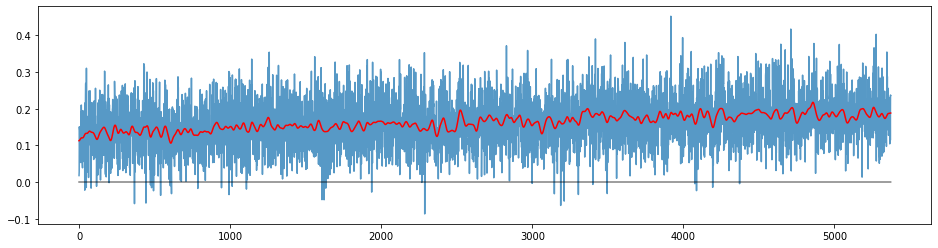

In [7]:
agent.env.mode = "train"
agent.learning_log.episodes = 0
agent.learn(
    timesteps=-1, 
    log_every=100,
    success_threshold_lookback=1000,
    success_strict=True,
)

In [ ]:
success = 0
n_tests = 10000

scores = []
targets = []

for i in trange(n_tests):
    state = agent.env.reset(visualize=False,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)

    while not done:
        agent.env.render()
        #state = np.expand_dims(state, axis=0)
        action, action_onehot, prediction = agent.act(state)
        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, _ = agent.env.step(action)
        #print(action, reward, agent.env.portfolio_value)
        # Memorize (state, action, reward) for training
        #self.buffer.remember(np.expand_dims(state, axis=0), action_onehot, reward)
        # Update current state
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1

        step+=1
        state = next_state
        score += reward
    
    #print(score,initial_portfolio, agent.env.portfolio_value)
    scores.append(score)
    
test_results_dataframe = pd.DataFrame([[
    n_tests,
    str(np.mean(scores)*100)+'%',
    str(np.mean(targets)*100)+'%',
    str(min(scores)*100)+'%',
    str(max(scores)*100)+'%',
    str((success/n_tests)*100) +'%'
]],
    columns=[
        '# Blind tests',
        '% Average portfolio return', 
        '% Desired portfolio return', 
        '% Historical minimum return',
        '% Historical maximum return', 
        '% Episode concluded with positive outcome'
    ]
)

# print(np.mean(scores))
# print(min(scores))
# print(max(scores))
# print(success)

test_results_dataframe.T

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
agent.results_writer.store_test_results(agent,test_results_dataframe)

In [ ]:
# from datetime import datetime

# test_results_dataframe.to_csv(agent.writer_log_directory+'/results__'+datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv')

In [ ]:
success = 0
n_tests = 2

scores = []
targets = []


for i in trange(n_tests):
    state = agent.env.reset(visualize=True,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
    initial_portfolio = agent.env.portfolio_value

    while not done:
        agent.env.render()
        #state = np.expand_dims(state, axis=0)
        action, action_onehot, prediction = agent.act(state)
        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, _ = agent.env.step(action)
        #print(action, reward, agent.env.portfolio_value)
        # Memorize (state, action, reward) for training
        #self.buffer.remember(np.expand_dims(state, axis=0), action_onehot, reward)
        # Update current state
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1

        step+=1
        state = next_state
        score += reward
    
    #print(score,initial_portfolio, agent.env.portfolio_value)
    scores.append(score)

agent.env.close()